# Clean-up raw job logs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys, os
sys.path.append('..')
from tools import read_request_logs

## Read the raw job logs
Load raw job logs from the much more performant Parquet storage format, if already available...

In [3]:
if os.path.isfile('job_logs_raw.parquet'):
    job_logs_raw = pd.read_parquet('job_logs_raw.parquet')
else:
    job_logs_raw = read_request_logs('../request_logs/', '*.tar.gz')
    job_logs_raw.to_parquet('job_logs_raw.parquet', index=False, compression='gzip')

In [4]:
job_logs_raw

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Identifier,Time,Filename
0,clbigmem,0,RUN,-,45.40,10000.86,560223.0,Y,Y,Y,1.0,50f38293dabf53e9,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
1,clbigmem,0,RUN,-,66.43,1461501.36,181504.0,Y,Y,Y,1.0,1cadd9af115874fc,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
2,clbigmem,0,RUN,-,44.20,2973694.55,93235.0,Y,Y,Y,1.0,84b513a49a615a33,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
3,clbigmem,0,RUN,-,2.01,1166604.28,36574.0,Y,Y,Y,3.0,817f139219e72642,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
4,clbigmem,0,RUN,-,30.28,138055.86,4353.0,Y,Y,Y,1.0,fc3ffa2fca1e77be,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998495,vequeue,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,f4cb580b6bec844d,2020-06-04 09:11:32+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
3998496,vequeue,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,c4975bdf8e8eed3e,2020-06-04 09:11:32+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
3998497,vequeue,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,1f285dcb7a982b97,2020-06-04 09:11:32+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
3998498,vequeue,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,046400ed28c790fe,2020-06-04 09:11:32+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz


## Information content assessment
We go through each of the columns in the above Pandas dataframe and check which rows/columns contain valuable/necessary information for the follow-up analysis. We try to drop as many columns as possible.

In [5]:
def job_prevalence(logs, parameter):
    grouped = logs.groupby(parameter)
    total_job_number = logs['Time'].count()
    print(grouped[parameter].count()/total_job_number*100)

### Batch class
The majority of job entries (about 94.7%) is located on the Linux cluster, i.e. in the `cl*` and the `feque` batch classes. We will limit the analysis to this most occupied part of the system and will drop job entries for the vector host `ve*` part (about 5.0%) and those for the interactive `clintera` and experimental `cltestqu` batch classes (about 0.3%). As the existence of distinct batch classes might affect user behaviour the column will be kept.

In [6]:
job_prevalence(job_logs_raw, 'Queue')

Queue
clbigmem     2.390521
clexpres     0.856421
clfo2        5.532650
clintera     0.247543
cllong      25.315218
clmedium    58.808553
cltestqu     0.030661
feque        1.783469
veexpres     1.194373
veintera     0.034963
vequeue      3.805627
Name: Queue, dtype: float64


In [7]:
100*job_logs_raw['Queue'].str.contains('clbigmem|cllong|clmedium|clexpres|feque|clfo2').sum()/job_logs_raw['Time'].count()

94.68683256221082

In [8]:
100*job_logs_raw['Queue'].str.contains('veexpres|veintera|vequeue').sum()/job_logs_raw['Time'].count()

5.034963111166688

In [9]:
100*job_logs_raw['Queue'].str.contains('clintera|cltestqu').sum()/job_logs_raw['Time'].count()

0.27820432662248346

### Job priority
Apparently, all jobs entries have the same priority. There is no valuable information here, the `Pri` column will thus be dropped.

In [10]:
job_prevalence(job_logs_raw, 'Pri')

Pri
0    100.0
Name: Pri, dtype: float64


### Job status
The majority of the job entries (about 99.4%) is either in a queued or running state. We keep the column with job status information, as these are important for the estimation of job characteristics. The job states will likely need a post-processing, but how that should be done will depend on the target analysis and will thus be done separately.

In [11]:
job_prevalence(job_logs_raw, 'STT')

STT
EXT     0.296611
HLD     0.083906
POR     0.012805
PRR     0.044267
QUE    47.602926
RUN    51.841666
STG     0.008953
WAT     0.108866
Name: STT, dtype: float64


In [12]:
100*job_logs_raw['STT'].str.contains('QUE|RUN').sum()/job_logs_raw['Time'].count()

99.4445917218957

Job request states as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC.

```
ARI arriving
CHK checkpointing
EXT exiting
FWD forwarding
GQD global_queued
HLD held
HOL holding
MIG migrating
POR post-running
PRR pre-running
QUE queued
RST restarting
RUN running
SUS suspending, suspended, resuming
STG staging
TRS transferring
WAT waiting
```

### Stall status
Jobs that are stalled (about 0.004% of the job entries and 0.002% of the individual jobs) will be dropped as they are elapsing w/o using CPU and memory resources. If we do this, the column can be dropped.

In [13]:
job_prevalence(job_logs_raw, 'S')

S
-    99.995698
Y     0.004302
Name: S, dtype: float64


In [14]:
these_identifiers = job_logs_raw[job_logs_raw['S']=='Y']['Identifier'].unique()
100*these_identifiers.size/job_logs_raw['Identifier'].unique().size

0.0018707148936966261

Stall states as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC.

```
Stall Status (S)
Y Stall
Normal
```

In [15]:
these_jobs = job_logs_raw.set_index("Identifier")['S'].str.contains('Y')
job_logs_raw.set_index("Identifier").loc[these_jobs]

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Time,Filename
Identifier,,,,,,,,,,,,,
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,68145.0,Y,Y,Y,NaN,2020-02-18 20:36:55+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,68750.0,Y,Y,Y,NaN,2020-02-18 20:47:00+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,69355.0,Y,Y,Y,NaN,2020-02-18 20:57:06+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,69959.0,Y,Y,Y,NaN,2020-02-18 21:07:09+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,70564.0,Y,Y,Y,NaN,2020-02-18 21:17:14+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,170975.0,Y,Y,Y,NaN,2020-02-20 01:10:45+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,171582.0,Y,Y,Y,NaN,2020-02-20 01:20:53+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,172189.0,Y,Y,Y,NaN,2020-02-20 01:31:00+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz


### Scheduler options
The job re-execution, the job hold and the job migration scheduler options are set to `yes` for the majority of job entries. A closer investigation reveals that only jobs in the interactive batch classes `clintera` and `veintera` are marked with a `no` for this option. As jobs in these batch classes will be dropped anyway, the scheduler options column will be dropped too.

In [16]:
job_prevalence(job_logs_raw, 'R')

R
N     0.282506
Y    99.717494
Name: R, dtype: float64


As documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC.

```
Re-execution Possible/Not Possible (R)
Y Request with re-execution option
N Request without re-execution option
```

In [17]:
job_prevalence(job_logs_raw, 'H')

H
N     0.282506
Y    99.717494
Name: H, dtype: float64


As documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC.

```
Hold Possible/Not Possible (H)
Y Request with hold option
N Request without hold option
```

In [18]:
job_prevalence(job_logs_raw, 'M')

M
N     0.282506
Y    99.717494
Name: M, dtype: float64


As documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC.

```
Job Migration Possible/Not Possible (M)
Y Request with Job Migration option
N Request without Job Migration option
```

In [20]:
for column in ['R', 'H', 'M']:
    print(column, job_logs_raw.set_index(column).loc['N']['Queue'].unique())

R ['veintera' 'clintera']
H ['veintera' 'clintera']
M ['veintera' 'clintera']


### Jobs per job request
For full node requests this can be interpreted as total node number. This is valuable information and the column will thus be kept.

In [21]:
job_prevalence(job_logs_raw, 'Jobs')

Jobs
1.0     81.863349
2.0      2.475103
3.0      2.274153
4.0     11.900788
5.0      0.058072
6.0      0.107440
7.0      0.056346
8.0      0.929574
10.0     0.048368
16.0     0.251219
29.0     0.000025
30.0     0.002401
32.0     0.028461
64.0     0.000400
Name: Jobs, dtype: float64


## Data integrity assessments
There could be more of these...

### Logging time step and identifier uniqueness
The logging time step should be close to about ten minutes, which is the value currently set in the logging script. The way in which this analysis is implemented (grouping the job log entries by identifier and calculating time deltas separately for each identifier, which helps to circumvent the discontinuity at the termination and restart of log cycles in comparison to a purely log file name time step based approach) is also a quick check for job identifier uniqueness (note that only a cropped hash is written to disk by the logging script and that, though very unlikely, hashes could re-appear). We find, that the logging time step is mostly 10-11 minutes (never above 15:51 minutes), and thus also basically that no multiple job identifiers occur. Therefore, no clean-ups are necessary here.

In [22]:
delta_timestamp = job_logs_raw.groupby("Identifier")["Time"].apply(lambda subgroup: subgroup.diff().max())

In [23]:
delta_timestamp = delta_timestamp.sort_values(ascending=False)

In [24]:
delta_timestamp.min(), delta_timestamp.max()

(Timedelta('0 days 00:10:00'), Timedelta('0 days 00:15:51'))

Text(0.5, 0, 'Logging period in minutes')

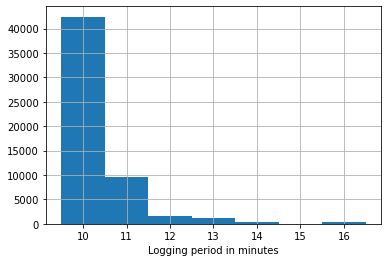

In [25]:
(delta_timestamp.astype('timedelta64[s]')/60).hist(bins=np.arange(9.5,17.5,1))
plt.xlabel('Logging period in minutes')

### Number of batch classes per job

We would expect that each job is assigned to exactly one batch class. However, there are a few jobs (about 0.01%) that were moved manually into another batch class after long waiting times... we keep this information for now.

In [26]:
queues_per_identifier = job_logs_raw.groupby("Identifier")["Queue"].nunique()
100*(queues_per_identifier>1).sum()/queues_per_identifier.size

0.03086679574599433

In [27]:
these_identifiers = queues_per_identifier.index[queues_per_identifier > 1]

In [28]:
job_logs_raw.set_index("Identifier").loc[these_identifiers[3]].sort_values("Time")

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Time,Filename
Identifier,,,,,,,,,,,,,
15f8e91ac6df1c5a,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,4.0,2020-05-22 00:33:10+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
15f8e91ac6df1c5a,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,4.0,2020-05-22 00:43:11+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
15f8e91ac6df1c5a,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,4.0,2020-05-22 00:53:12+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
15f8e91ac6df1c5a,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,4.0,2020-05-22 01:03:13+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
15f8e91ac6df1c5a,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,4.0,2020-05-22 01:13:13+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15f8e91ac6df1c5a,clbigmem,0,RUN,-,2.22,359017.89,11287.0,Y,Y,Y,4.0,2020-05-22 11:55:26+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
15f8e91ac6df1c5a,clbigmem,0,RUN,-,2.22,378150.57,11893.0,Y,Y,Y,4.0,2020-05-22 12:05:31+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz
15f8e91ac6df1c5a,clbigmem,0,RUN,-,2.22,397313.26,12494.0,Y,Y,Y,4.0,2020-05-22 12:15:33+02:00,../request_logs/cycle_2020-04-28-10-32-05.tar.gz


### Resource documentation
Interestingly, about 0.06% of the jobs don't document their resource usage during `RUN` states. We will keep them for now, but this should be kept in mind for follow-up analyses.

In [29]:
subset = (job_logs_raw.set_index('Identifier')['STT']=='RUN') & job_logs_raw.set_index('Identifier')['Elapse'].isna()

In [30]:
these_identifiers = job_logs_raw.set_index('Identifier')[subset].index.unique()

In [31]:
100*these_identifiers.size/job_logs_raw['Identifier'].unique().size

0.05892751915144372

In [32]:
job_logs_raw.set_index('Identifier').loc[these_identifiers[0]]

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Time,Filename
Identifier,,,,,,,,,,,,,
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 11:43:16+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 11:54:09+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 12:04:51+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 12:15:40+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 12:26:27+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 12:37:12+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 12:48:39+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 12:59:22+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
75bc9d7758dce369,clexpres,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,2020-02-07 13:10:07+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz


In [33]:
job_logs_raw.set_index('Identifier').loc[these_identifiers]['Jobs'].unique()

array([1.])

In [34]:
job_logs_raw.set_index('Identifier').loc[these_identifiers]['Queue'].unique()

array(['clexpres', 'clmedium', 'cllong', 'clbigmem'], dtype=object)

## Clean-up raw dataframe now
And show what fraction of the original job entries remains after each single operation.

In [35]:
original_job_log_length = len(job_logs_raw)

### Keep only Linux cluster jobs

In [36]:
job_logs_raw['Queue'].unique()

array(['clbigmem', 'clfo2', 'cllong', 'clmedium', 'veexpres', 'vequeue',
       'clexpres', 'feque', 'veintera', 'clintera', 'cltestqu'],
      dtype=object)

In [37]:
keep_these_batch_classes = 'clbigmem|cllong|clmedium|clexpres|feque|clfo2'
keep_these_jobs = job_logs_raw.set_index("Identifier")['Queue'].str.contains(keep_these_batch_classes)

In [38]:
job_logs_raw = job_logs_raw.set_index('Identifier').loc[keep_these_jobs]
job_logs_raw = job_logs_raw.reset_index()

In [39]:
100*len(job_logs_raw)/original_job_log_length

94.68683256221082

### Drop the stalled jobs

In [40]:
drop_these = job_logs_raw.set_index('S').loc['Y']['Identifier'].unique()

In [41]:
job_logs_raw = job_logs_raw.set_index("Identifier").drop(index=drop_these).reset_index()

In [42]:
100*len(job_logs_raw)/original_job_log_length

94.6742528448168

### Convert log cycle information
This information should be kept for now, too.

In [43]:
job_logs_raw['Cycle'] = pd.to_datetime('2020-01-01').tz_localize(tz='Europe/Berlin')

for filename in job_logs_raw['Filename'].unique():
    job_logs_raw['Cycle'].mask(
        job_logs_raw['Filename'].str.contains(filename),
        pd.to_datetime(filename.split('_')[-1].split('.')[0],
           format='%Y-%m-%d-%H-%M-%S').tz_localize(tz='Europe/Berlin'),
        inplace=True
    )

In [44]:
job_logs_raw.drop(columns=['Filename'], inplace=True)

### Finally drop also the obsolete columns

In [45]:
job_logs_raw.drop(columns=['Pri', 'S', 'R', 'H', 'M'], inplace=True)

## Store logs on disk

In [46]:
job_logs_raw.to_parquet('job_logs.parquet', index=False, compression='gzip')

In [47]:
job_logs_raw

,Identifier,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
0,50f38293dabf53e9,clbigmem,RUN,45.40,10000.86,560223.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
1,1cadd9af115874fc,clbigmem,RUN,66.43,1461501.36,181504.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
2,84b513a49a615a33,clbigmem,RUN,44.20,2973694.55,93235.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
3,817f139219e72642,clbigmem,RUN,2.01,1166604.28,36574.0,3.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
4,fc3ffa2fca1e77be,clbigmem,RUN,30.28,138055.86,4353.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...,...
3785545,6cefcc4dd03175f4,clmedium,QUE,0.00,0.00,0.0,1.0,2020-06-04 09:11:32+02:00,2020-04-28 10:32:05+02:00
3785546,73d229aa76a5ae95,clmedium,QUE,0.00,0.00,0.0,1.0,2020-06-04 09:11:32+02:00,2020-04-28 10:32:05+02:00
3785547,3e84ada85baccae0,clmedium,QUE,0.00,0.00,0.0,1.0,2020-06-04 09:11:32+02:00,2020-04-28 10:32:05+02:00
3785548,638fe8e683508cfd,clmedium,QUE,0.00,0.00,0.0,1.0,2020-06-04 09:11:32+02:00,2020-04-28 10:32:05+02:00


## Appendix

In [48]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.4.5.1-hecc5488_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.34-h53a641e_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-7.3.0-hdf63c60_5.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.2.0-hdf63c60_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/llvm-openmp-10.0.0-hc9558a2_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_openmp_mutex-4.5-1_llvm.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgcc-ng-9.2.0-h24d8f2e_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/abseil-cpp-20200225.2-he1b5a44_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/brotli-1.0.7-he1b5a44_1001.tar.bz2